In [ ]:
pip install tensorflow

In [1]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
data_train = pd.read_csv('fashion-mnist_train.csv')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size
= 0.3)

In [5]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [97]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Dropout, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras import Model

class ResidualBlock(Model):
    def __init__(self, channel_in = 64, channel_out = 256):
        super().__init__()
        
        channel = channel_out // 4
        
        self.conv1 = Conv2D(channel, kernel_size = (1, 1), padding = "same")
        self.bn1 = BatchNormalization()
        self.av1 = Activation(tf.nn.relu)
        self.conv2 = Conv2D(channel, kernel_size = (3, 3), padding = "same")
        self.bn2 = BatchNormalization()
        self.av2 = Activation(tf.nn.relu)
        self.conv3 = Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
        self.bn3 = BatchNormalization()
        self.shortcut = self._shortcut(channel_in, channel_out)
        self.add = Add()
        self.av3 = Activation(tf.nn.relu)
        
    def call(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.av1(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.av2(h)
        h = self.conv3(h)
        h = self.bn3(h)
        shortcut = self.shortcut(x)
        h = self.add([h, shortcut])
        y = self.av3(h)
        return y
    
    def _shortcut(self, channel_in, channel_out):
        if channel_in == channel_out:
            return lambda x : x
        else:
            return self._projection(channel_out)
        
    def _projection(self, channel_out):
        return Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
           
class ResNext50(Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()                
        
        self._layers = [
            # conv1
            Conv2D(64, input_shape = input_shape, kernel_size = (7, 7), strides=(2, 2), padding = "same"),
            BatchNormalization(),
            Activation(tf.nn.relu),
            # conv2_x
            MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same"),
            Dropout(0.5),
            [
                ResidualBlock(128, 256) for _ in range(3)                
            ],
            [
                ResidualBlock(256, 512) for _ in range(4)                
            ],
            [
                ResidualBlock(512, 1024) for _ in range(6)                
            ],
            [
                ResidualBlock(1024, 2048) for _ in range(3)
           ],
             Dropout(0.5),
            # last part
            GlobalAveragePooling2D(),
            Dense(output_dim, activation = tf.nn.softmax)
        ]
        
    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    x = l(x)    
            else:
                x = layer(x)
        return x
       
    
model = ResNext50((28, 28, 1), 10)
model.build(input_shape = (None, 28, 28, 1))
model.summary()

Model: "res_next50_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_456 (Conv2D)         multiple                  3200      
                                                                 
 batch_normalization_425 (Ba  multiple                 256       
 tchNormalization)                                               
                                                                 
 activation_424 (Activation)  multiple                 0         
                                                                 
 max_pooling2d_13 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 residual_block_134 (Residua  multiple                

In [ ]:

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [59]:
model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=30,
    validation_data=(x_test, y_test),
    shuffle=True,
)

Epoch 1/30
165/165 [==============================] - 151s 879ms/step - loss: 0.7928 - accuracy: 0.7019 - val_loss: 4.2024 - val_accuracy: 0.1042
Epoch 2/30
165/165 [==============================] - 142s 863ms/step - loss: 0.4935 - accuracy: 0.8164 - val_loss: 1.7370 - val_accuracy: 0.5159
Epoch 3/30
165/165 [==============================] - 134s 811ms/step - loss: 0.4161 - accuracy: 0.8445 - val_loss: 0.5306 - val_accuracy: 0.8076
Epoch 4/30
165/165 [==============================] - 134s 813ms/step - loss: 0.3719 - accuracy: 0.8618 - val_loss: 0.5098 - val_accuracy: 0.8260
Epoch 5/30
165/165 [==============================] - 134s 813ms/step - loss: 0.3527 - accuracy: 0.8691 - val_loss: 0.3782 - val_accuracy: 0.8639
Epoch 6/30
165/165 [==============================] - 134s 814ms/step - loss: 0.3306 - accuracy: 0.8764 - val_loss: 0.3413 - val_accuracy: 0.8784
Epoch 7/30
165/165 [==============================] - 141s 855ms/step - loss: 0.3228 - accuracy: 0.8807 - val_loss: 0.3767 -

In [60]:
model.evaluate(x_test, y_test)
     

563/563 [==============================] - 21s 37ms/step - loss: 0.2772 - accuracy: 0.9062


[0.27722498774528503, 0.9062222242355347]

In [ ]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
#ділить всі дані на групи по класах
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

In [7]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
        # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)


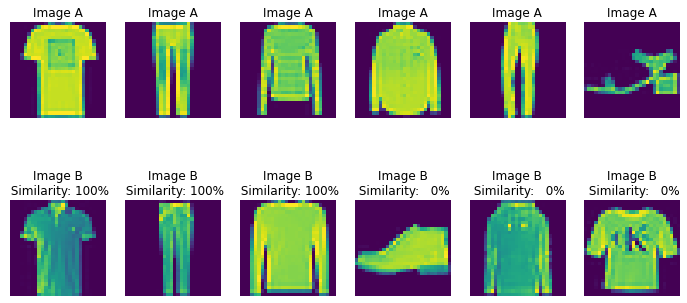

In [9]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [12]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D,Activation, Flatten, Dense, Dropout

img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name ='FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 28, 28, 1)]      0         
 tLayer)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 8)        32        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 26, 26, 8)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 16)        1168      
                                                                 
 batch_normalization_2 (Batc  (None, 24, 24,

In [88]:
from keras.layers import concatenate
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name ='merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs =[combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 32)          25040       ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 64)           0           ['FeatureGeneratio

In [89]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy',
metrics = ['mae'])

In [90]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(
    siam_gen(train_groups),
    steps_per_epoch = 500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs = 10,
    verbose = True
)

Epoch 1/10


C:\Users\sonia\AppData\Local\Temp/ipykernel_7132/2494138960.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = similarity_model.fit_generator(


500/500 [==============================] - 49s 89ms/step - loss: 0.6142 - mae: 0.4456 - val_loss: 0.4515 - val_mae: 0.2970
Epoch 2/10
500/500 [==============================] - 45s 89ms/step - loss: 0.4371 - mae: 0.3070 - val_loss: 0.3368 - val_mae: 0.1910
Epoch 3/10
500/500 [==============================] - 46s 92ms/step - loss: 0.3740 - mae: 0.2490 - val_loss: 0.3020 - val_mae: 0.1815
Epoch 4/10
500/500 [==============================] - 43s 86ms/step - loss: 0.3563 - mae: 0.2315 - val_loss: 0.3262 - val_mae: 0.1774
Epoch 5/10
500/500 [==============================] - 42s 83ms/step - loss: 0.3517 - mae: 0.2261 - val_loss: 0.2968 - val_mae: 0.1641
Epoch 6/10
500/500 [==============================] - 42s 84ms/step - loss: 0.3258 - mae: 0.2084 - val_loss: 0.2994 - val_mae: 0.1631
Epoch 7/10
500/500 [==============================] - 42s 84ms/step - loss: 0.3296 - mae: 0.2092 - val_loss: 0.2903 - val_mae: 0.1747
Epoch 8/10
500/500 [==============================] - 42s 84ms/step - los

In [91]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose = True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose = True, batch_size = 128)

141/141 [==============================] - 8s 53ms/step


[1.0000000e+00 1.2246468e-16 6.1232340e-17 1.0000000e+00]


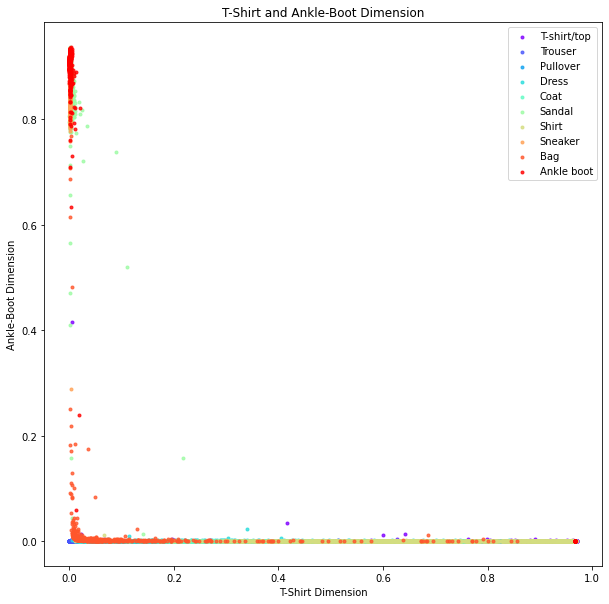

In [92]:
obj_categories = [
    'T-shirt/top','Trouser','Pullover','Dress',
    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
print(c_color)
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        t_shirt_score[np.where(y_test == c_group), 0],
        ankle_boot_score[np.where(y_test == c_group), 0],
        marker='.',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

1/1 [==============================] - 0s 63ms/step


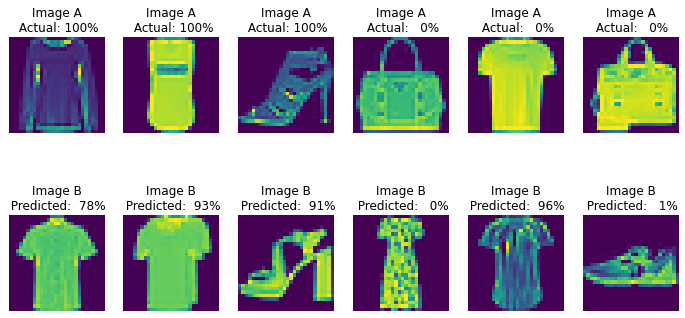

In [93]:
def show_model_output(nb_examples=3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:, :, 0])
        ax1.set_title("Image A\n Actual: %3.0f%%" % (100 * c_d))
        ax1.axis("off")
        ax2.imshow(c_b[:, :, 0])
        ax2.set_title("Image B\n Predicted: %3.0f%%" % (100 * p_d))
        ax2.axis("off")
    return fig


_ = show_model_output()

In [94]:
x_test_features = feature_model.predict(x_test, verbose = True, batch_size=128)

141/141 [==============================] - 5s 33ms/step


In [95]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(
    n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.002s...


C:\Users\sonia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 18000 samples in 12.003s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sample 13000 / 18000
[t-SNE] Computed conditional probabilities for sample 14000 / 1800

C:\Users\sonia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 81.9476166, gradient norm = 0.0018678 (50 iterations in 10.066s)
[t-SNE] Iteration 100: error = 80.0313263, gradient norm = 0.0011906 (50 iterations in 9.722s)
[t-SNE] Iteration 150: error = 79.0452881, gradient norm = 0.0008088 (50 iterations in 9.051s)
[t-SNE] Iteration 200: error = 78.4903564, gradient norm = 0.0006166 (50 iterations in 12.635s)
[t-SNE] Iteration 250: error = 78.1293106, gradient norm = 0.0005018 (50 iterations in 10.072s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.129311
[t-SNE] Iteration 300: error = 3.2230783, gradient norm = 0.0012041 (50 iterations in 10.372s)
[t-SNE] Iteration 350: error = 2.7269497, gradient norm = 0.0006317 (50 iterations in 10.927s)
[t-SNE] Iteration 400: error = 2.4266686, gradient norm = 0.0003976 (50 iterations in 10.709s)
[t-SNE] Iteration 450: error = 2.2351651, gradient norm = 0.0002824 (50 iterations in 10.489s)
[t-SNE] Iteration 500: error = 2.1026163, gradient norm = 0.00021

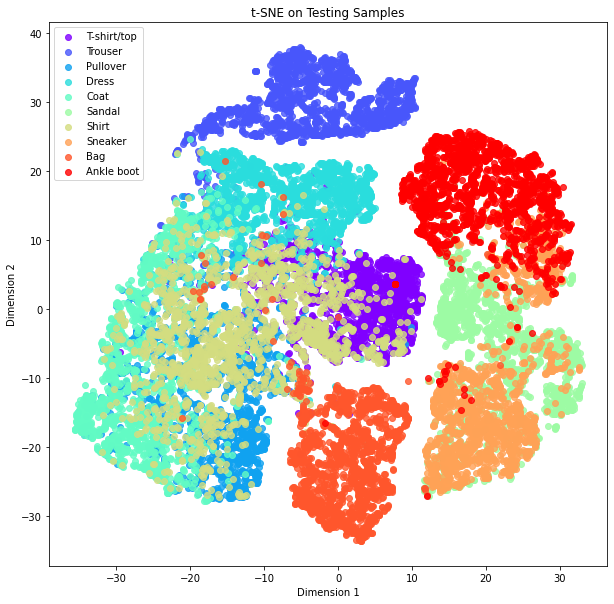

In [96]:
obj_categories = [
    'T-shirt/top','Trouser','Pullover','Dress',
    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)